In [3]:
# !pip install ipykernel
# !python -m ipykernel install --user 

Installed kernelspec python3 in C:\Users\NAMAN\AppData\Roaming\jupyter\kernels\python3


In [7]:
# !pip list

In [83]:
import numpy as np
np.__version__

'1.23.5'

In [84]:
!pip install mtcnn

In [85]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [87]:
# demonstrate face detection on our Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# # specify folder to plot
# folder = 'mydata/train/naman/'
# i = 1
# # enumerate files
# for filename in listdir(folder):
# 	# path
# 	path = folder + filename
# 	# get face
# 	face = extract_face(path)
# 	print(i, face.shape)
# 	# plot
# 	pyplot.subplot(2, 7, i)
# 	pyplot.axis('off')
# 	pyplot.imshow(face)
# 	i += 1
# pyplot.show()

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
# face detection for our Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('mydata/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('mydata/val/')
# save arrays to one file in compressed format
savez_compressed('faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 10 examples for class: anant


>loaded 10 examples for class: himanshu


>loaded 10 examples for class: jashan


>loaded 10 examples for class: naman
(40, 160, 160, 3) (40,)


>loaded 4 examples for class: anant
>loaded 4 examples for class: himanshu


>loaded 4 examples for class: jashan


>loaded 4 examples for class: naman


In [90]:
!pip install keras-facenet

In [91]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
# from keras.models import load_model
from keras_facenet import FaceNet


# load the face dataset
data = load('faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
embedder = FaceNet()
# model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = embedder.extract(face_pixels, threshold=0.95)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
# print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = embedder.extract(face_pixels, threshold=0.95)
    print(embedding)
    # get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
# print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (40, 160, 160, 3) (40,) (16, 160, 160, 3) (16,)
Loaded Model
[{'box': [1, 0, 150, 165], 'confidence': 0.9999418258666992, 'keypoints': {'left_eye': (49, 49), 'right_eye': (119, 51), 'nose': (85, 80), 'mouth_left': (50, 118), 'mouth_right': (111, 118)}, 'embedding': array([-7.67722214e-03,  1.91242360e-02,  1.71080772e-02, -4.10887152e-02,
       -2.86153909e-02,  1.38525488e-02,  8.68410245e-02, -1.65032279e-02,
        3.71567085e-02, -3.07042468e-02,  2.47267261e-02, -1.45184752e-02,
       -1.78141880e-03,  7.38691166e-03,  4.15793210e-02, -5.46960160e-02,
       -9.27053206e-03,  4.78992015e-02, -1.26694385e-02,  1.10416282e-02,
       -6.22928664e-02, -1.14088543e-02,  4.87622917e-02, -2.51086603e-04,
       -1.77126415e-02,  1.91206299e-02, -6.43048733e-02, -3.42737287e-02,
        6.42120559e-03, -3.84974629e-02,  6.15107827e-02,  9.11295414e-02,
       -1.04371097e-03,  5.28178662e-02,  2.84782853e-02,  3.37871648e-02,
       -1.53757248e-03,  9.57968924e-03,  8.795619

[{'box': [1, 0, 150, 165], 'confidence': 0.9999418258666992, 'keypoints': {'left_eye': (49, 49), 'right_eye': (119, 51), 'nose': (85, 80), 'mouth_left': (50, 118), 'mouth_right': (111, 118)}, 'embedding': array([-7.67722214e-03,  1.91242360e-02,  1.71080772e-02, -4.10887152e-02,
       -2.86153909e-02,  1.38525488e-02,  8.68410245e-02, -1.65032279e-02,
        3.71567085e-02, -3.07042468e-02,  2.47267261e-02, -1.45184752e-02,
       -1.78141880e-03,  7.38691166e-03,  4.15793210e-02, -5.46960160e-02,
       -9.27053206e-03,  4.78992015e-02, -1.26694385e-02,  1.10416282e-02,
       -6.22928664e-02, -1.14088543e-02,  4.87622917e-02, -2.51086603e-04,
       -1.77126415e-02,  1.91206299e-02, -6.43048733e-02, -3.42737287e-02,
        6.42120559e-03, -3.84974629e-02,  6.15107827e-02,  9.11295414e-02,
       -1.04371097e-03,  5.28178662e-02,  2.84782853e-02,  3.37871648e-02,
       -1.53757248e-03,  9.57968924e-03,  8.79561901e-03,  2.04056147e-02,
        8.31924602e-02, -1.04964510e-01,  1.1

[{'box': [1, 0, 150, 165], 'confidence': 0.9999418258666992, 'keypoints': {'left_eye': (49, 49), 'right_eye': (119, 51), 'nose': (85, 80), 'mouth_left': (50, 118), 'mouth_right': (111, 118)}, 'embedding': array([-7.67722214e-03,  1.91242360e-02,  1.71080772e-02, -4.10887152e-02,
       -2.86153909e-02,  1.38525488e-02,  8.68410245e-02, -1.65032279e-02,
        3.71567085e-02, -3.07042468e-02,  2.47267261e-02, -1.45184752e-02,
       -1.78141880e-03,  7.38691166e-03,  4.15793210e-02, -5.46960160e-02,
       -9.27053206e-03,  4.78992015e-02, -1.26694385e-02,  1.10416282e-02,
       -6.22928664e-02, -1.14088543e-02,  4.87622917e-02, -2.51086603e-04,
       -1.77126415e-02,  1.91206299e-02, -6.43048733e-02, -3.42737287e-02,
        6.42120559e-03, -3.84974629e-02,  6.15107827e-02,  9.11295414e-02,
       -1.04371097e-03,  5.28178662e-02,  2.84782853e-02,  3.37871648e-02,
       -1.53757248e-03,  9.57968924e-03,  8.79561901e-03,  2.04056147e-02,
        8.31924602e-02, -1.04964510e-01,  1.1

[{'box': [1, 0, 150, 165], 'confidence': 0.9999418258666992, 'keypoints': {'left_eye': (49, 49), 'right_eye': (119, 51), 'nose': (85, 80), 'mouth_left': (50, 118), 'mouth_right': (111, 118)}, 'embedding': array([-7.67722214e-03,  1.91242360e-02,  1.71080772e-02, -4.10887152e-02,
       -2.86153909e-02,  1.38525488e-02,  8.68410245e-02, -1.65032279e-02,
        3.71567085e-02, -3.07042468e-02,  2.47267261e-02, -1.45184752e-02,
       -1.78141880e-03,  7.38691166e-03,  4.15793210e-02, -5.46960160e-02,
       -9.27053206e-03,  4.78992015e-02, -1.26694385e-02,  1.10416282e-02,
       -6.22928664e-02, -1.14088543e-02,  4.87622917e-02, -2.51086603e-04,
       -1.77126415e-02,  1.91206299e-02, -6.43048733e-02, -3.42737287e-02,
        6.42120559e-03, -3.84974629e-02,  6.15107827e-02,  9.11295414e-02,
       -1.04371097e-03,  5.28178662e-02,  2.84782853e-02,  3.37871648e-02,
       -1.53757248e-03,  9.57968924e-03,  8.79561901e-03,  2.04056147e-02,
        8.31924602e-02, -1.04964510e-01,  1.1

[{'box': [5, 0, 148, 160], 'confidence': 0.9999953508377075, 'keypoints': {'left_eye': (41, 59), 'right_eye': (109, 56), 'nose': (74, 90), 'mouth_left': (44, 119), 'mouth_right': (108, 116)}, 'embedding': array([ 3.71282808e-02, -1.05757127e-02, -3.75067405e-02,  4.17233109e-02,
       -7.76213706e-02,  4.05274071e-02,  3.74007709e-02,  7.40652382e-02,
        5.03865071e-03,  1.60859413e-02,  2.11285576e-02,  4.31282036e-02,
        2.04198845e-02, -6.72016898e-03, -4.51944359e-02,  7.84511492e-02,
       -2.30266321e-02, -2.64897067e-02, -4.75676358e-03,  5.61853312e-03,
       -5.54173365e-02, -4.70804721e-02, -9.12671350e-03, -6.49424363e-03,
        3.47715467e-02,  2.35337690e-02, -4.09418382e-02, -1.60950460e-02,
       -6.11538514e-02, -2.10387539e-02, -2.73213629e-03,  7.72265866e-02,
       -4.49727811e-02,  2.78052054e-02, -4.49022837e-02,  1.29036643e-02,
        3.07677388e-02, -8.88176553e-04, -4.65910882e-02,  8.52094498e-03,
        4.00171056e-02, -1.89470407e-02, -3.7

[{'box': [5, 0, 148, 160], 'confidence': 0.9999953508377075, 'keypoints': {'left_eye': (41, 59), 'right_eye': (109, 56), 'nose': (74, 90), 'mouth_left': (44, 119), 'mouth_right': (108, 116)}, 'embedding': array([ 3.71282808e-02, -1.05757127e-02, -3.75067405e-02,  4.17233109e-02,
       -7.76213706e-02,  4.05274071e-02,  3.74007709e-02,  7.40652382e-02,
        5.03865071e-03,  1.60859413e-02,  2.11285576e-02,  4.31282036e-02,
        2.04198845e-02, -6.72016898e-03, -4.51944359e-02,  7.84511492e-02,
       -2.30266321e-02, -2.64897067e-02, -4.75676358e-03,  5.61853312e-03,
       -5.54173365e-02, -4.70804721e-02, -9.12671350e-03, -6.49424363e-03,
        3.47715467e-02,  2.35337690e-02, -4.09418382e-02, -1.60950460e-02,
       -6.11538514e-02, -2.10387539e-02, -2.73213629e-03,  7.72265866e-02,
       -4.49727811e-02,  2.78052054e-02, -4.49022837e-02,  1.29036643e-02,
        3.07677388e-02, -8.88176553e-04, -4.65910882e-02,  8.52094498e-03,
        4.00171056e-02, -1.89470407e-02, -3.7

[{'box': [5, 0, 148, 160], 'confidence': 0.9999953508377075, 'keypoints': {'left_eye': (41, 59), 'right_eye': (109, 56), 'nose': (74, 90), 'mouth_left': (44, 119), 'mouth_right': (108, 116)}, 'embedding': array([ 3.71282808e-02, -1.05757127e-02, -3.75067405e-02,  4.17233109e-02,
       -7.76213706e-02,  4.05274071e-02,  3.74007709e-02,  7.40652382e-02,
        5.03865071e-03,  1.60859413e-02,  2.11285576e-02,  4.31282036e-02,
        2.04198845e-02, -6.72016898e-03, -4.51944359e-02,  7.84511492e-02,
       -2.30266321e-02, -2.64897067e-02, -4.75676358e-03,  5.61853312e-03,
       -5.54173365e-02, -4.70804721e-02, -9.12671350e-03, -6.49424363e-03,
        3.47715467e-02,  2.35337690e-02, -4.09418382e-02, -1.60950460e-02,
       -6.11538514e-02, -2.10387539e-02, -2.73213629e-03,  7.72265866e-02,
       -4.49727811e-02,  2.78052054e-02, -4.49022837e-02,  1.29036643e-02,
        3.07677388e-02, -8.88176553e-04, -4.65910882e-02,  8.52094498e-03,
        4.00171056e-02, -1.89470407e-02, -3.7

[{'box': [5, 0, 148, 160], 'confidence': 0.9999953508377075, 'keypoints': {'left_eye': (41, 59), 'right_eye': (109, 56), 'nose': (74, 90), 'mouth_left': (44, 119), 'mouth_right': (108, 116)}, 'embedding': array([ 3.71282808e-02, -1.05757127e-02, -3.75067405e-02,  4.17233109e-02,
       -7.76213706e-02,  4.05274071e-02,  3.74007709e-02,  7.40652382e-02,
        5.03865071e-03,  1.60859413e-02,  2.11285576e-02,  4.31282036e-02,
        2.04198845e-02, -6.72016898e-03, -4.51944359e-02,  7.84511492e-02,
       -2.30266321e-02, -2.64897067e-02, -4.75676358e-03,  5.61853312e-03,
       -5.54173365e-02, -4.70804721e-02, -9.12671350e-03, -6.49424363e-03,
        3.47715467e-02,  2.35337690e-02, -4.09418382e-02, -1.60950460e-02,
       -6.11538514e-02, -2.10387539e-02, -2.73213629e-03,  7.72265866e-02,
       -4.49727811e-02,  2.78052054e-02, -4.49022837e-02,  1.29036643e-02,
        3.07677388e-02, -8.88176553e-04, -4.65910882e-02,  8.52094498e-03,
        4.00171056e-02, -1.89470407e-02, -3.7

[{'box': [3, 0, 151, 169], 'confidence': 0.9999955892562866, 'keypoints': {'left_eye': (45, 61), 'right_eye': (119, 53), 'nose': (85, 90), 'mouth_left': (62, 126), 'mouth_right': (121, 118)}, 'embedding': array([ 1.25126503e-02,  5.95760271e-02, -3.33088497e-03,  7.53581524e-02,
       -3.07911821e-02,  6.44808039e-02,  8.80126841e-03,  8.22997466e-02,
       -2.44652778e-02, -2.65637273e-03,  9.56307650e-02,  3.60212382e-03,
        5.88186458e-02,  4.66301814e-02, -2.72390805e-02,  1.96259730e-02,
       -2.71655358e-02,  5.58194285e-03, -3.20594362e-03, -5.60386106e-02,
       -2.45788824e-02, -5.66375209e-03, -3.93655784e-02, -1.00097982e-02,
        1.66485421e-02, -1.05726235e-02, -5.52620403e-02,  3.39935198e-02,
        4.45351191e-02, -5.50903082e-02, -4.13050409e-03,  6.68334030e-03,
       -1.25642223e-02, -3.76374722e-02,  1.26952236e-03,  5.91224320e-02,
        5.89780174e-02, -1.92131922e-02,  4.04847600e-02, -4.13227789e-02,
       -1.50990682e-02,  3.25808823e-02,  5.7

[{'box': [3, 0, 151, 169], 'confidence': 0.9999955892562866, 'keypoints': {'left_eye': (45, 61), 'right_eye': (119, 53), 'nose': (85, 90), 'mouth_left': (62, 126), 'mouth_right': (121, 118)}, 'embedding': array([ 1.25126503e-02,  5.95760271e-02, -3.33088497e-03,  7.53581524e-02,
       -3.07911821e-02,  6.44808039e-02,  8.80126841e-03,  8.22997466e-02,
       -2.44652778e-02, -2.65637273e-03,  9.56307650e-02,  3.60212382e-03,
        5.88186458e-02,  4.66301814e-02, -2.72390805e-02,  1.96259730e-02,
       -2.71655358e-02,  5.58194285e-03, -3.20594362e-03, -5.60386106e-02,
       -2.45788824e-02, -5.66375209e-03, -3.93655784e-02, -1.00097982e-02,
        1.66485421e-02, -1.05726235e-02, -5.52620403e-02,  3.39935198e-02,
        4.45351191e-02, -5.50903082e-02, -4.13050409e-03,  6.68334030e-03,
       -1.25642223e-02, -3.76374722e-02,  1.26952236e-03,  5.91224320e-02,
        5.89780174e-02, -1.92131922e-02,  4.04847600e-02, -4.13227789e-02,
       -1.50990682e-02,  3.25808823e-02,  5.7

[{'box': [0, 0, 152, 161], 'confidence': 0.9999988079071045, 'keypoints': {'left_eye': (46, 57), 'right_eye': (116, 64), 'nose': (77, 92), 'mouth_left': (41, 117), 'mouth_right': (104, 124)}, 'embedding': array([ 1.48756467e-02,  2.81562489e-02, -4.58571576e-02,  7.98244551e-02,
       -4.96696644e-02,  6.44937009e-02, -1.35209840e-02,  7.78815821e-02,
       -4.04133983e-02,  2.26591416e-02,  3.67312320e-02, -9.25633777e-03,
        2.61503290e-02,  1.84787903e-02, -2.15903446e-02, -7.57557899e-03,
       -3.87337953e-02,  9.16783884e-03,  3.42564769e-02, -2.51746993e-03,
       -3.82187963e-02,  2.34228708e-02, -5.54963797e-02, -2.56167594e-02,
        2.72257924e-02,  1.80994030e-02, -9.06190090e-03,  4.44334410e-02,
        6.68690947e-04, -3.24652940e-02,  1.74619548e-03,  4.76553701e-02,
       -5.62034082e-03, -2.01462153e-02, -6.44824132e-02,  3.50372121e-02,
        2.04294734e-02,  4.16715406e-02,  6.51861131e-02, -6.54578358e-02,
       -6.02587759e-02,  5.31155914e-02,  4.9

[{'box': [0, 0, 152, 161], 'confidence': 0.9999988079071045, 'keypoints': {'left_eye': (46, 57), 'right_eye': (116, 64), 'nose': (77, 92), 'mouth_left': (41, 117), 'mouth_right': (104, 124)}, 'embedding': array([ 1.48756467e-02,  2.81562489e-02, -4.58571576e-02,  7.98244551e-02,
       -4.96696644e-02,  6.44937009e-02, -1.35209840e-02,  7.78815821e-02,
       -4.04133983e-02,  2.26591416e-02,  3.67312320e-02, -9.25633777e-03,
        2.61503290e-02,  1.84787903e-02, -2.15903446e-02, -7.57557899e-03,
       -3.87337953e-02,  9.16783884e-03,  3.42564769e-02, -2.51746993e-03,
       -3.82187963e-02,  2.34228708e-02, -5.54963797e-02, -2.56167594e-02,
        2.72257924e-02,  1.80994030e-02, -9.06190090e-03,  4.44334410e-02,
        6.68690947e-04, -3.24652940e-02,  1.74619548e-03,  4.76553701e-02,
       -5.62034082e-03, -2.01462153e-02, -6.44824132e-02,  3.50372121e-02,
        2.04294734e-02,  4.16715406e-02,  6.51861131e-02, -6.54578358e-02,
       -6.02587759e-02,  5.31155914e-02,  4.9

[{'box': [7, 4, 146, 160], 'confidence': 0.9999881982803345, 'keypoints': {'left_eye': (46, 68), 'right_eye': (115, 67), 'nose': (78, 100), 'mouth_left': (47, 122), 'mouth_right': (117, 120)}, 'embedding': array([-7.97121450e-02, -1.26075353e-02, -2.75942963e-02, -1.96954310e-02,
       -6.94027450e-03, -2.22226139e-02,  1.37174070e-01,  2.86929049e-02,
        4.39840294e-02, -4.86562178e-02,  4.29546982e-02, -8.54715984e-03,
        6.11453690e-02,  2.74241660e-02,  5.37984213e-03, -6.57306239e-02,
       -6.34685829e-02,  1.28598521e-02,  1.98062300e-03, -5.08201355e-03,
       -6.16924558e-03, -6.79733232e-03,  4.24704254e-02, -4.78960387e-02,
        4.39774338e-03, -5.79443127e-02,  7.44431792e-03, -5.67921698e-02,
        9.25148954e-04, -2.92860903e-02,  5.64295277e-02,  2.72396021e-02,
       -3.04664746e-02,  1.67186074e-02,  3.72755900e-02,  4.04339097e-02,
       -4.55692075e-02,  7.26039112e-02, -2.75305826e-02, -2.89365109e-02,
        1.97970029e-02, -2.21739188e-02, -1.

[{'box': [7, 4, 146, 160], 'confidence': 0.9999881982803345, 'keypoints': {'left_eye': (46, 68), 'right_eye': (115, 67), 'nose': (78, 100), 'mouth_left': (47, 122), 'mouth_right': (117, 120)}, 'embedding': array([-7.97121450e-02, -1.26075353e-02, -2.75942963e-02, -1.96954310e-02,
       -6.94027450e-03, -2.22226139e-02,  1.37174070e-01,  2.86929049e-02,
        4.39840294e-02, -4.86562178e-02,  4.29546982e-02, -8.54715984e-03,
        6.11453690e-02,  2.74241660e-02,  5.37984213e-03, -6.57306239e-02,
       -6.34685829e-02,  1.28598521e-02,  1.98062300e-03, -5.08201355e-03,
       -6.16924558e-03, -6.79733232e-03,  4.24704254e-02, -4.78960387e-02,
        4.39774338e-03, -5.79443127e-02,  7.44431792e-03, -5.67921698e-02,
        9.25148954e-04, -2.92860903e-02,  5.64295277e-02,  2.72396021e-02,
       -3.04664746e-02,  1.67186074e-02,  3.72755900e-02,  4.04339097e-02,
       -4.55692075e-02,  7.26039112e-02, -2.75305826e-02, -2.89365109e-02,
        1.97970029e-02, -2.21739188e-02, -1.

[{'box': [7, 4, 146, 160], 'confidence': 0.9999881982803345, 'keypoints': {'left_eye': (46, 68), 'right_eye': (115, 67), 'nose': (78, 100), 'mouth_left': (47, 122), 'mouth_right': (117, 120)}, 'embedding': array([-7.97121450e-02, -1.26075353e-02, -2.75942963e-02, -1.96954310e-02,
       -6.94027450e-03, -2.22226139e-02,  1.37174070e-01,  2.86929049e-02,
        4.39840294e-02, -4.86562178e-02,  4.29546982e-02, -8.54715984e-03,
        6.11453690e-02,  2.74241660e-02,  5.37984213e-03, -6.57306239e-02,
       -6.34685829e-02,  1.28598521e-02,  1.98062300e-03, -5.08201355e-03,
       -6.16924558e-03, -6.79733232e-03,  4.24704254e-02, -4.78960387e-02,
        4.39774338e-03, -5.79443127e-02,  7.44431792e-03, -5.67921698e-02,
        9.25148954e-04, -2.92860903e-02,  5.64295277e-02,  2.72396021e-02,
       -3.04664746e-02,  1.67186074e-02,  3.72755900e-02,  4.04339097e-02,
       -4.55692075e-02,  7.26039112e-02, -2.75305826e-02, -2.89365109e-02,
        1.97970029e-02, -2.21739188e-02, -1.

[{'box': [7, 4, 146, 160], 'confidence': 0.9999881982803345, 'keypoints': {'left_eye': (46, 68), 'right_eye': (115, 67), 'nose': (78, 100), 'mouth_left': (47, 122), 'mouth_right': (117, 120)}, 'embedding': array([-7.97121450e-02, -1.26075353e-02, -2.75942963e-02, -1.96954310e-02,
       -6.94027450e-03, -2.22226139e-02,  1.37174070e-01,  2.86929049e-02,
        4.39840294e-02, -4.86562178e-02,  4.29546982e-02, -8.54715984e-03,
        6.11453690e-02,  2.74241660e-02,  5.37984213e-03, -6.57306239e-02,
       -6.34685829e-02,  1.28598521e-02,  1.98062300e-03, -5.08201355e-03,
       -6.16924558e-03, -6.79733232e-03,  4.24704254e-02, -4.78960387e-02,
        4.39774338e-03, -5.79443127e-02,  7.44431792e-03, -5.67921698e-02,
        9.25148954e-04, -2.92860903e-02,  5.64295277e-02,  2.72396021e-02,
       -3.04664746e-02,  1.67186074e-02,  3.72755900e-02,  4.04339097e-02,
       -4.55692075e-02,  7.26039112e-02, -2.75305826e-02, -2.89365109e-02,
        1.97970029e-02, -2.21739188e-02, -1.

In [92]:

# develop a classifier for given Dataset
import numpy
from sklearn import metrics
# from sklearn.metrics import accuracy_score
from sklearn import preprocessing
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import Normalizer
from sklearn import svm
# from sklearn.svm import SVC
# load dataset
data = numpy.load('faces-embeddings.npz', allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

newtx = []
pp =[]
for x in range(len(trainX)):
  try:
    tmpx = trainX[x][0]['embedding']
    newtx.append(tmpx)
  except:
    pp.append(x)

trainy = list(trainy)
for i in sorted(pp, reverse=True):
    print(trainy[i])
    del trainy[i]

newttx = []
ppt=[]
for x in range(len(testX)):
  try:
    tmpx = testX[x][0]['embedding']
    newttx.append(tmpx)
  except:
    ppt.append(x)

testy = list(testy)
for i in sorted(ppt, reverse=True):
    print(testy[i])
    del testy[i]


# normalize input vectors
in_encoder = preprocessing.Normalizer(norm='l2')
trainX = in_encoder.transform(newtx)
testX = in_encoder.transform(newttx)
# label encode targets
out_encoder = preprocessing.LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = svm.SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = metrics.accuracy_score(trainy, yhat_train)
score_test = metrics.accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=40, test=16
Accuracy: train=100.000, test=100.000


Predicted: 
['anant' 'himanshu' 'jashan' 'naman'] 
[79.33901533  6.30830835  5.9529283   8.39974801]
Predicted: anant
Expected: anant


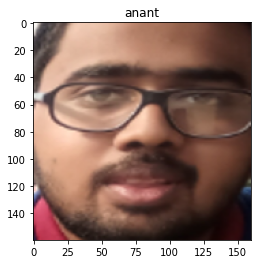

In [103]:
# develop a classifier for given Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = numpy.load('faces-dataset.npz', allow_pickle=True)
testX_faces = data['arr_2']
# load face embeddings
data = numpy.load('faces-embeddings.npz', allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

newtx = []
pp =[]
for x in range(len(trainX)):
  try:
    tmpx = trainX[x][0]['embedding']
    newtx.append(tmpx)
  except:
    pp.append(x)

trainy = list(trainy)
for i in sorted(pp, reverse=True):
    print(trainy[i])
    del trainy[i]

newttx = []
ppt=[]
for x in range(len(testX)):
  try:
    tmpx = testX[x][0]['embedding']
    newttx.append(tmpx)
  except:
    ppt.append(x)

testy = list(testy)
for i in sorted(ppt, reverse=True):
    print(testy[i])
    del testy[i]


# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newtx)
testX = in_encoder.transform(newttx)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3])
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Predicted: %s' % (predict_names[0]))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s' % (predict_names[0])
pyplot.title(title)
pyplot.show()